<a href="https://colab.research.google.com/github/kumarand-tcs/AIML-Projects/blob/main/AL_Users_TweetSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Importing the libraries, load dataset, print shape of data, data description**

In [54]:
!pip install contractions

import  re
import  string 
import  unicodedata                                                            # Import Regex, string and unicodedata.
import  contractions                                                           # Import contractions library.
import  numpy                           as np                                  # Import numpy.
import  pandas                          as pd                                  # Import pandas.
import  matplotlib.pyplot               as plt
import  seaborn                         as sns
import  nltk                                                                   # Import Natural Language Tool-Kit.

from    nltk.corpus                     import stopwords                       # Import stopwords.
from    nltk.tokenize                   import word_tokenize, sent_tokenize    # Import Tokenizer.
from    nltk.stem.wordnet               import WordNetLemmatizer               # Import Lemmatizer.
from    bs4                             import BeautifulSoup                   # Import BeautifulSoup.
from    sklearn                         import preprocessing
from    sklearn.feature_extraction.text import CountVectorizer
from    sklearn.feature_extraction.text import TfidfVectorizer
from    sklearn.model_selection         import train_test_split
from    sklearn.ensemble                import RandomForestClassifier
from    sklearn.model_selection         import cross_val_score
from    sklearn.metrics                 import confusion_matrix


nltk.download('stopwords')                                                     # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
# load dataset from GitHub directly.
dt_aluts = pd.read_csv('https://github.com/kumarand-tcs/AIML-Projects/blob/main/Tweets.csv?raw=true')

In [12]:
dt_aluts.shape

(14640, 15)

In [13]:
dt_aluts.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [14]:
dt_aluts.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# **2. Understand of data-columns**

2.a Drop all other columns except “text” and “airline_sentiment”.

In [33]:
dt_aluts_cp = dt_aluts.copy(deep=True)
for cols in dt_aluts.columns:
  if (cols != 'airline_sentiment' and cols != 'text'):
    dt_aluts_cp.drop([cols], axis=1, inplace=True)

2.b Check the shape of data

In [34]:
dt_aluts_cp.shape

(14640, 2)

2.c Print first 5 rows of data.

In [35]:
dt_aluts_cp.head(5)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


# **3. Text pre-processing: Data preparation**

3.a Html tag removal.

In [36]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

dt_aluts_cp['text'] = dt_aluts_cp['text'].apply(lambda x: strip_html(x))
dt_aluts_cp.head(5)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [37]:
def replace_contractions(text):
    """Replace contractions in string of input text"""
    return contractions.fix(text)

dt_aluts_cp['text'] = dt_aluts_cp['text'].apply(lambda x: replace_contractions(x))
dt_aluts_cp.head(5)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials...
2,neutral,@VirginAmerica I did not today... Must mean I ...
3,negative,@VirginAmerica it is really aggressive to blas...
4,negative,@VirginAmerica and it is a really big bad thin...


3.b Tokenization

In [38]:
# Tokenization of data
dt_aluts_cp['text'] = dt_aluts_cp.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
for i in dt_aluts_cp['text'][0]:
  print(i)

@
VirginAmerica
What
@
dhepburn
said
.


3.c Remove the numbers

In [39]:
dt_aluts_cp['text'][0]

['@', 'VirginAmerica', 'What', '@', 'dhepburn', 'said', '.']

In [42]:
def remove_numbers(textList):
  for tokenIndex in range(0, len(textList)):
    textList[tokenIndex] = re.sub(r'\d+', '', textList[tokenIndex])
  return textList

dt_aluts_cp['text'] = dt_aluts_cp['text'].apply(lambda x: remove_numbers(x))
dt_aluts_cp.head(5)

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, have, added, com..."
2,neutral,"[@, VirginAmerica, I, did, not, today, ..., Mu..."
3,negative,"[@, VirginAmerica, it, is, really, aggressive,..."
4,negative,"[@, VirginAmerica, and, it, is, a, really, big..."


3.d Removal of Special Characters and Punctuations

In [44]:
def remove_punctuation(words):
    """Remove punctuation from inputed list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words
dt_aluts_cp['text'] = dt_aluts_cp['text'].apply(lambda x: remove_punctuation(x))    
dt_aluts_cp.head(5)

,airline_sentiment,text
0,neutral,"[VirginAmerica, What, dhepburn, said]"
1,positive,"[VirginAmerica, plus, you, have, added, commer..."
2,neutral,"[VirginAmerica, I, did, not, today, Must, mean..."
3,negative,"[VirginAmerica, it, is, really, aggressive, to..."
4,negative,"[VirginAmerica, and, it, is, a, really, big, b..."


3.e Conversion to lowercase

In [45]:
def to_lowercase(words):
    """Convert all characters to lowercase from inputed list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
dt_aluts_cp['text'] = dt_aluts_cp['text'].apply(lambda x: to_lowercase(x))    
dt_aluts_cp.head(5)

,airline_sentiment,text
0,neutral,"[virginamerica, what, dhepburn, said]"
1,positive,"[virginamerica, plus, you, have, added, commer..."
2,neutral,"[virginamerica, i, did, not, today, must, mean..."
3,negative,"[virginamerica, it, is, really, aggressive, to..."
4,negative,"[virginamerica, and, it, is, a, really, big, b..."


3.f Lemmatize or stemming

In [46]:
lemmatizer = WordNetLemmatizer()
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words
dt_aluts_cp['text'] = dt_aluts_cp['text'].apply(lambda x: lemmatize_list(x))    
dt_aluts_cp.head(5)    

,airline_sentiment,text
0,neutral,"[virginamerica, what, dhepburn, say]"
1,positive,"[virginamerica, plus, you, have, add, commerci..."
2,neutral,"[virginamerica, i, do, not, today, must, mean,..."
3,negative,"[virginamerica, it, be, really, aggressive, to..."
4,negative,"[virginamerica, and, it, be, a, really, big, b..."


3.g Join the words in the list to convert back to text string in the dataframe. (So that each row contains the data in text format.)

In [47]:
def normalize(words):   
    return ' '.join(words)
dt_aluts_cp['text'] = dt_aluts_cp['text'].apply(lambda x: normalize(x)) 
dt_aluts_cp.head(5)

,airline_sentiment,text
0,neutral,virginamerica what dhepburn say
1,positive,virginamerica plus you have add commercials to...
2,neutral,virginamerica i do not today must mean i need ...
3,negative,virginamerica it be really aggressive to blast...
4,negative,virginamerica and it be a really big bad thing...


3.h Print first 5 rows of data after pre-processing

In [49]:
dt_aluts_cp.head(5)  

,airline_sentiment,text
0,neutral,virginamerica what dhepburn say
1,positive,virginamerica plus you have add commercials to...
2,neutral,virginamerica i do not today must mean i need ...
3,negative,virginamerica it be really aggressive to blast...
4,negative,virginamerica and it be a really big bad thing...


# **4. Vectorization**

4.a Use CountVectorizer

In [50]:
dt_aluts_cp['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [52]:
le = preprocessing.LabelEncoder()
le.fit(["negative", "neutral", "positive"])
list(le.classes_)
dt_aluts_cp['label'] = le.transform(dt_aluts_cp['airline_sentiment'])

In [55]:
# copy for CountVectorizer
dt_aluts_cv = dt_aluts_cp.copy(deep=True) 

In [56]:
# Keep only 1000 features as number of features will increase the processing time.

ct_vect = CountVectorizer(max_features=1000)                
cv_feat = ct_vect.fit_transform(dt_aluts_cv['text'])

# Convert the data features to array.

cv_feat = cv_feat.toarray()                        

In [57]:
cv_feat.shape

(14640, 1000)

In [62]:
cv_lbl = dt_aluts_cv['label']
cv_lbl = cv_lbl.astype('int')

4.b Use TfidfVectorizer

In [76]:
dt_aluts_tdv = dt_aluts_cp.copy(deep=True)

td_vect = TfidfVectorizer(max_features=1000)
tv_feat = td_vect.fit_transform(dt_aluts_tdv['text'])

tv_feat = tv_feat.toarray()

tv_lbl = dt_aluts_tdv['label']
tv_lbl = tv_lbl.astype('int')

tv_feat.shape

(14640, 1000)

In [69]:
tv_feat.size

14640000

# **5. Fit and evaluate model using both type of vectorization**

5.a Fit and evaluation model for CountVectorizer

In [77]:
# Split data into training and testing set.

X_train, X_test, y_train, y_test = train_test_split(cv_feat, cv_lbl, test_size=0.3, random_state=78)

# Using Random Forest to build model for the classification of reviews.Also calculating the cross validation score.

cv_model = RandomForestClassifier(n_estimators=10, n_jobs=4)

cv_model = cv_model.fit(X_train, y_train)

print(cv_model)

print(np.mean(cross_val_score(cv_model, cv_feat, cv_lbl, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7184426229508196


[[2551  139   50]
 [ 448  378   64]
 [ 289  121  352]]


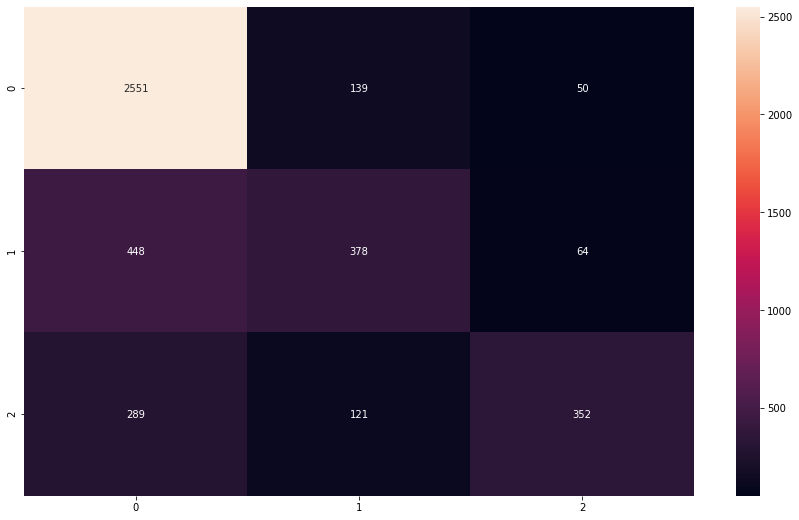

In [79]:
cv_rslt = cv_model.predict(X_test)

conf_mat = confusion_matrix(y_test, cv_rslt)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in range(0, 3)], columns = [i for i in range(0, 3)])
plt.figure(figsize = (15,9))
sns.heatmap(df_cm, annot=True, fmt='g')

5.b Fit and evaluation model for TfidfVectorizer 

In [81]:
# Split data into training and testing set.

X_train, X_test, y_train, y_test = train_test_split(tv_feat, tv_lbl, test_size=0.3, random_state=88)

tv_model = RandomForestClassifier(n_estimators=10, n_jobs=4)
tv_model = tv_model.fit(X_train, y_train)
print(tv_model)
print(np.mean(cross_val_score(tv_model, tv_feat, tv_lbl, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7129781420765027


[[2081  395  297]
 [ 714  134   93]
 [ 493  109   76]]


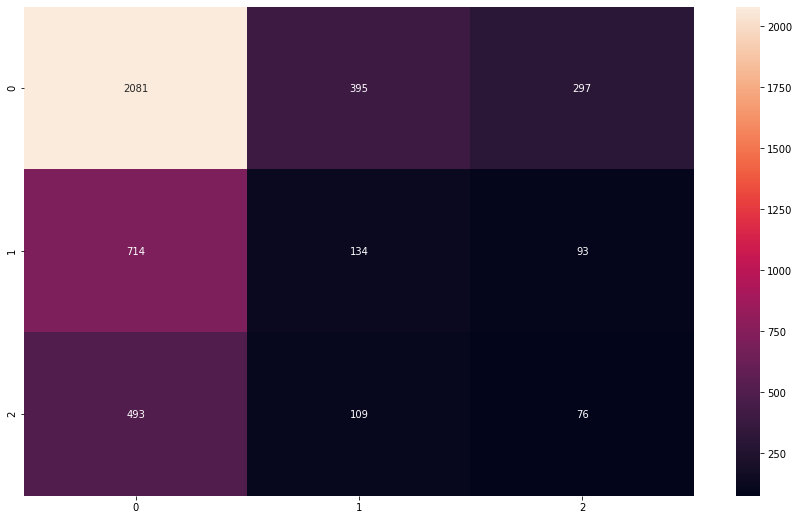

In [82]:
tv_rslt = tv_model.predict(X_test)

conf_mat = confusion_matrix(y_test, cv_rslt)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in range(0, 3)], columns = [i for i in range(0, 3)])
plt.figure(figsize = (15,9))
sns.heatmap(df_cm, annot=True, fmt='g')

# **6. Summarize your understanding of the application of Various Pre-processing and Vectorization and performance of your model on this dataset**

Summary:

1. Airline feedback dataset from twitter which had reviews in text format and their sentiment score on the scale of 0,1 & 2. 
0 - Negative
1 - Neutral 
2 - Positive
2. Pre-processed the data using various NLP techniques as asked.
3. Models performed equally on both count vectorizer and TF-IDF.
4. However the Count Vectorizer has perfromed a little better compared to TF-IDF vectorizer.
5. Overall both model performed same.
